# BigMart - XGBoost (Hyperparameter Tuning)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm, tqdm_notebook

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('final_train.csv')

In [3]:
# LEt's seggregate the target and independent variables first
X = df.drop(columns= 'Item_Outlet_Sales', axis=1)
Y = df['Item_Outlet_Sales']

# Let's scale the independent variables and store them in a dataframe
ss = StandardScaler()
X_scaled = ss.fit_transform(X)
x = pd.DataFrame(X_scaled, columns= X.columns)

# merge the independent and target variables to create a new dataframe with scaled features
scaled_df= pd.concat([x,Y], axis=1)
scaled_df.head(2)

,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Item_Weight_y,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,...,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Outlet_Sales
0,-0.737887,-0.970891,1.763875,0.133879,0.285343,-1.365170,-0.768435,-0.28777,-0.174363,-0.114158,...,-0.344522,-0.350919,-0.35007,-0.350495,2.847938,-0.382818,0.723256,-0.350707,-0.344522,3735.1380
1,1.355222,-0.908348,-1.486518,1.331598,0.285343,1.095912,-1.496059,-0.28777,-0.174363,-0.114158,...,-0.344522,-0.350919,-0.35007,-0.350495,-0.351131,-0.382818,-1.382637,2.851384,-0.344522,443.4228


We will tune the following hyperparamters in the XGBRegressor:

* n_estimators
* max_depth
* learning_rate
* subsample
* min_child_weight
* gamma

### 1. n_estimators

In [17]:
def estimator_score(data, min_r=1, max_r=10):
    
    X = data.drop(columns = 'Item_Outlet_Sales', axis= 1)
    Y = data['Item_Outlet_Sales']
    
    KF = KFold(n_splits= 5, shuffle= True, random_state= 0)
    
    results= []
    
    for n_est in tqdm_notebook(range(min_r, max_r, 20), desc="Processing", leave=True):
        x = {}
        train_score = []
        val_score = []
        
        for i, (train_index, val_index) in enumerate(KF.split(X, Y)):
            xtr, xval = X.iloc[train_index], X.iloc[val_index]
            ytr, yval = Y.iloc[train_index], Y.iloc[val_index]
        
            model = XGBRegressor(n_estimators = n_est,
                                    learning_rate = 0.01,
                                    n_jobs = 4,
                                    random_state = 0,
                                    objective = 'reg:squarederror')
            
            model.fit(xtr, ytr)

            train_preds = model.predict(xtr)
            val_preds = model.predict(xval)

            train_rmse = np.sqrt(mse(ytr, train_preds))
            val_rmse = np.sqrt(mse(yval, val_preds))

            train_score.append(train_rmse)
            val_score.append(val_rmse)
            
            
        mean_score_train = np.mean(train_score)
        mean_score_valid = np.mean(val_score)

        print('With n_estimators:\t' + str(n_est) + '\tMean_RMSLE_Train:\t' + str(mean_score_train) + '\tMean_RMSLE_Valid:\t' + str(mean_score_valid))
                 
        x['estimators'] = n_est
        x['train'] = mean_score_train
        x['valid'] = mean_score_valid
    
        results.append(x)
        
    return pd.DataFrame(results)

In [19]:
est_results = estimator_score(scaled_df, min_r= 20, max_r= 800)

Processing:   0%|          | 0/39 [00:00<?, ?it/s]

With n_estimators:	20	Mean_RMSLE_Train:	2274.6592854451656	Mean_RMSLE_Valid:	2277.708227738834
With n_estimators:	40	Mean_RMSLE_Train:	1950.7362394116037	Mean_RMSLE_Valid:	1957.5117063276393
With n_estimators:	60	Mean_RMSLE_Train:	1698.629176377808	Mean_RMSLE_Valid:	1709.5555516050904
With n_estimators:	80	Mean_RMSLE_Train:	1505.285309856376	Mean_RMSLE_Valid:	1521.1422455157012
With n_estimators:	100	Mean_RMSLE_Train:	1359.3586755794045	Mean_RMSLE_Valid:	1379.962850096104
With n_estimators:	120	Mean_RMSLE_Train:	1250.9864346367026	Mean_RMSLE_Valid:	1276.5125518333036
With n_estimators:	140	Mean_RMSLE_Train:	1171.710041890736	Mean_RMSLE_Valid:	1202.308123944049
With n_estimators:	160	Mean_RMSLE_Train:	1114.414745017765	Mean_RMSLE_Valid:	1149.905551525284
With n_estimators:	180	Mean_RMSLE_Train:	1073.3086429089713	Mean_RMSLE_Valid:	1113.3275700849836
With n_estimators:	200	Mean_RMSLE_Train:	1043.677432380588	Mean_RMSLE_Valid:	1088.3814866279695
With n_estimators:	220	Mean_RMSLE_Train:	10

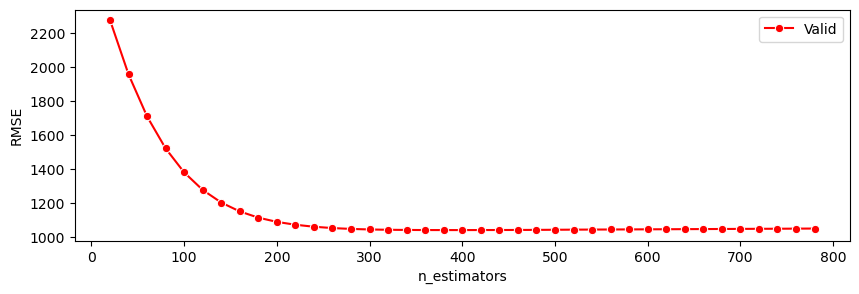

In [21]:
plt.figure(figsize= (10,3), dpi= 100)
#sns.lineplot(x= est_results['estimators'], y= est_results['train'], color = 'orange', marker= 'o', label= 'Train')
sns.lineplot(x= est_results['estimators'], y= est_results['valid'], color = 'red', marker= 'o', label= 'Valid')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.legend()
plt.show()

The **RMSE (1043.69)** is getting stable at **n_estimators = 300**

### 2. max_depth

In [22]:
def depth_score(data, min_r=1, max_r=10):
    
    X = data.drop(columns = 'Item_Outlet_Sales', axis= 1)
    Y = data['Item_Outlet_Sales']
    
    KF = KFold(n_splits= 5, shuffle= True, random_state= 0)
    
    results= []
    
    for depth in tqdm_notebook(range(min_r, max_r, 1), desc="Processing", leave=True):
        x = {}
        train_score = []
        val_score = []
        
        for i, (train_index, val_index) in enumerate(KF.split(X, Y)):
            xtr, xval = X.iloc[train_index], X.iloc[val_index]
            ytr, yval = Y.iloc[train_index], Y.iloc[val_index]
        
            model = XGBRegressor(n_estimators = 300,
                                 max_depth = depth,
                                    learning_rate = 0.01,
                                    n_jobs = 4,
                                    random_state = 0,
                                    objective = 'reg:squarederror')
            
            model.fit(xtr, ytr)

            train_preds = model.predict(xtr)
            val_preds = model.predict(xval)

            train_rmse = np.sqrt(mse(ytr, train_preds))
            val_rmse = np.sqrt(mse(yval, val_preds))

            train_score.append(train_rmse)
            val_score.append(val_rmse)
            
            
        mean_score_train = np.mean(train_score)
        mean_score_valid = np.mean(val_score)

        print('With max_depth:\t' + str(depth) + '\tMean_RMSLE_Train:\t' + str(mean_score_train) + '\tMean_RMSLE_Valid:\t' + str(mean_score_valid))
                 
        x['max_depth'] = depth
        x['train'] = mean_score_train
        x['valid'] = mean_score_valid
    
        results.append(x)
        
    return pd.DataFrame(results)

In [23]:
depth_result = depth_score(scaled_df, min_r= 1, max_r= 30)

Processing:   0%|          | 0/29 [00:00<?, ?it/s]

With max_depth:	1	Mean_RMSLE_Train:	1190.189670665206	Mean_RMSLE_Valid:	1194.4104639557797
With max_depth:	2	Mean_RMSLE_Train:	1056.0303165646442	Mean_RMSLE_Valid:	1063.2042511904408
With max_depth:	3	Mean_RMSLE_Train:	1030.4515041975342	Mean_RMSLE_Valid:	1042.2809390505752
With max_depth:	4	Mean_RMSLE_Train:	1017.5896971062368	Mean_RMSLE_Valid:	1038.5904184311034
With max_depth:	5	Mean_RMSLE_Train:	1001.4753354204768	Mean_RMSLE_Valid:	1040.1393922027553
With max_depth:	6	Mean_RMSLE_Train:	976.0017568774422	Mean_RMSLE_Valid:	1043.6947551278497
With max_depth:	7	Mean_RMSLE_Train:	940.6870368652347	Mean_RMSLE_Valid:	1049.8858072465605
With max_depth:	8	Mean_RMSLE_Train:	897.9211549839371	Mean_RMSLE_Valid:	1057.7494300818466
With max_depth:	9	Mean_RMSLE_Train:	850.2294042735593	Mean_RMSLE_Valid:	1066.1510627260254
With max_depth:	10	Mean_RMSLE_Train:	797.4180337629205	Mean_RMSLE_Valid:	1072.4599987559136
With max_depth:	11	Mean_RMSLE_Train:	742.7098743817099	Mean_RMSLE_Valid:	1081.8680427

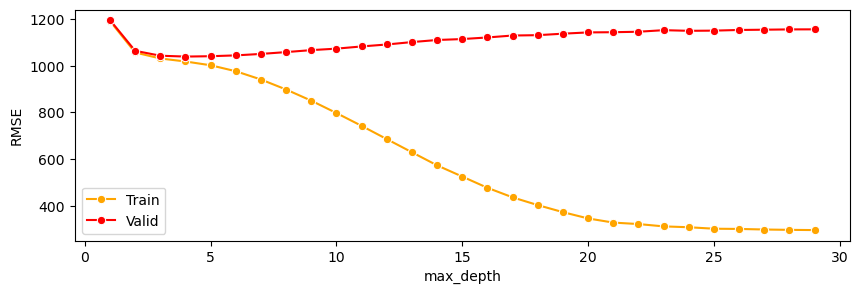

In [24]:
plt.figure(figsize= (10,3), dpi= 100)
sns.lineplot(x= depth_result['max_depth'], y= depth_result['train'], color = 'orange', marker= 'o', label= 'Train')
sns.lineplot(x= depth_result['max_depth'], y= depth_result['valid'], color = 'red', marker= 'o', label= 'Valid')
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.legend()
plt.show()

For **max_depth = 4**, the validation **RMSE (1038.59)** is the lowest. After this value the model has started to overfit on the training data.

### 3. min_child_weight

In [4]:
def mcw_score(data, min_r=1, max_r=10):
    
    X = data.drop(columns = 'Item_Outlet_Sales', axis= 1)
    Y = data['Item_Outlet_Sales']
    
    KF = KFold(n_splits= 5, shuffle= True, random_state= 0)
    
    results= []
    
    for mcw in tqdm_notebook(range(min_r, max_r, 1), desc="Processing", leave=True):
        x = {}
        train_score = []
        val_score = []
        
        for i, (train_index, val_index) in enumerate(KF.split(X, Y)):
            xtr, xval = X.iloc[train_index], X.iloc[val_index]
            ytr, yval = Y.iloc[train_index], Y.iloc[val_index]
        
            model = XGBRegressor(n_estimators = 300,
                                 max_depth = 4,
                                    learning_rate = 0.01,
                                 min_child_weight = mcw,
                                    n_jobs = 4,
                                    random_state = 0,
                                    objective = 'reg:squarederror')
            
            model.fit(xtr, ytr)

            train_preds = model.predict(xtr)
            val_preds = model.predict(xval)

            train_rmse = np.sqrt(mse(ytr, train_preds))
            val_rmse = np.sqrt(mse(yval, val_preds))

            train_score.append(train_rmse)
            val_score.append(val_rmse)
            
            
        mean_score_train = np.mean(train_score)
        mean_score_valid = np.mean(val_score)

        print('With min_child_weight:\t' + str(mcw) + '\tMean_RMSLE_Train:\t' + str(mean_score_train) + '\tMean_RMSLE_Valid:\t' + str(mean_score_valid))
                 
        x['mcw'] = mcw
        x['train'] = mean_score_train
        x['valid'] = mean_score_valid
    
        results.append(x)
        
    return pd.DataFrame(results)

In [7]:
mcw_results = mcw_score(scaled_df, min_r=1, max_r= 20)

Processing:   0%|          | 0/19 [00:00<?, ?it/s]

With min_child_weight:	1	Mean_RMSLE_Train:	1017.5896971062368	Mean_RMSLE_Valid:	1038.5904184311034
With min_child_weight:	2	Mean_RMSLE_Train:	1017.7214777801906	Mean_RMSLE_Valid:	1038.5558571455651
With min_child_weight:	3	Mean_RMSLE_Train:	1017.7120741962417	Mean_RMSLE_Valid:	1038.605359292263
With min_child_weight:	4	Mean_RMSLE_Train:	1018.0080284356318	Mean_RMSLE_Valid:	1038.3888673664285
With min_child_weight:	5	Mean_RMSLE_Train:	1018.0717642421627	Mean_RMSLE_Valid:	1038.286164513414
With min_child_weight:	6	Mean_RMSLE_Train:	1018.2345745880879	Mean_RMSLE_Valid:	1038.4101176989438
With min_child_weight:	7	Mean_RMSLE_Train:	1018.3746767476885	Mean_RMSLE_Valid:	1038.2231064182615
With min_child_weight:	8	Mean_RMSLE_Train:	1018.484704930921	Mean_RMSLE_Valid:	1038.1106775095222
With min_child_weight:	9	Mean_RMSLE_Train:	1018.5622849773578	Mean_RMSLE_Valid:	1037.989264352382
With min_child_weight:	10	Mean_RMSLE_Train:	1018.6221044417343	Mean_RMSLE_Valid:	1037.931487054667
With min_child

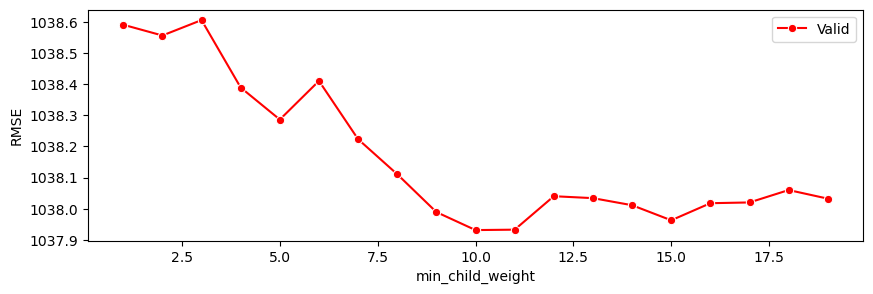

In [14]:
plt.figure(figsize= (10,3), dpi= 100)
#sns.lineplot(x= mcw_results['mcw'], y= mcw_results['train'], color = 'orange', marker= 'o', label= 'Train')
sns.lineplot(x= mcw_results['mcw'], y= mcw_results['valid'], color = 'red', marker= 'o', label= 'Valid')
plt.xlabel('min_child_weight')
plt.ylabel('RMSE')
plt.legend()
plt.show()

At **min_child_weight = 10** the **RMSE (1037.93)** is the lowest.

### 4. Gamma

In [23]:
def gamma_score(data):
    
    X = data.drop(columns = 'Item_Outlet_Sales', axis= 1)
    Y = data['Item_Outlet_Sales']
    
    KF = KFold(n_splits= 5, shuffle= True, random_state= 0)
    
    results= []
    
    for g in tqdm_notebook([0, 0.01, 0.1, 0.5, 1, 10, 100], desc="Processing", leave=True):
        x = {}
        train_score = []
        val_score = []
        
        for i, (train_index, val_index) in enumerate(KF.split(X, Y)):
            xtr, xval = X.iloc[train_index], X.iloc[val_index]
            ytr, yval = Y.iloc[train_index], Y.iloc[val_index]
        
            model = XGBRegressor(n_estimators = 300,
                                 max_depth = 4,
                                    learning_rate = 0.01,
                                 min_child_weight = 10,
                                 gamma = g,
                                    n_jobs = 4,
                                    random_state = 0,
                                    objective = 'reg:squarederror')
            
            model.fit(xtr, ytr)

            train_preds = model.predict(xtr)
            val_preds = model.predict(xval)

            train_rmse = np.sqrt(mse(ytr, train_preds))
            val_rmse = np.sqrt(mse(yval, val_preds))

            train_score.append(train_rmse)
            val_score.append(val_rmse)
            
            
        mean_score_train = np.mean(train_score)
        mean_score_valid = np.mean(val_score)

        print('With gamma:\t' + str(g) + '\tMean_RMSLE_Train:\t' + str(mean_score_train) + '\tMean_RMSLE_Valid:\t' + str(mean_score_valid))
                 
        x['gamma'] = g
        x['train'] = mean_score_train
        x['valid'] = mean_score_valid
    
        results.append(x)
        
    return pd.DataFrame(results)

In [16]:
gamma_results = gamma_score(scaled_df)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

With gamma:	0	Mean_RMSLE_Train:	1018.6221044417343	Mean_RMSLE_Valid:	1037.931487054667
With gamma:	0.01	Mean_RMSLE_Train:	1018.6221044417343	Mean_RMSLE_Valid:	1037.931487054667
With gamma:	0.1	Mean_RMSLE_Train:	1018.6221044417343	Mean_RMSLE_Valid:	1037.931487054667
With gamma:	0.5	Mean_RMSLE_Train:	1018.6221044417343	Mean_RMSLE_Valid:	1037.931487054667
With gamma:	1	Mean_RMSLE_Train:	1018.6221044417343	Mean_RMSLE_Valid:	1037.931487054667
With gamma:	10	Mean_RMSLE_Train:	1018.6221044417343	Mean_RMSLE_Valid:	1037.931487054667
With gamma:	100	Mean_RMSLE_Train:	1018.6221044417343	Mean_RMSLE_Valid:	1037.931487054667


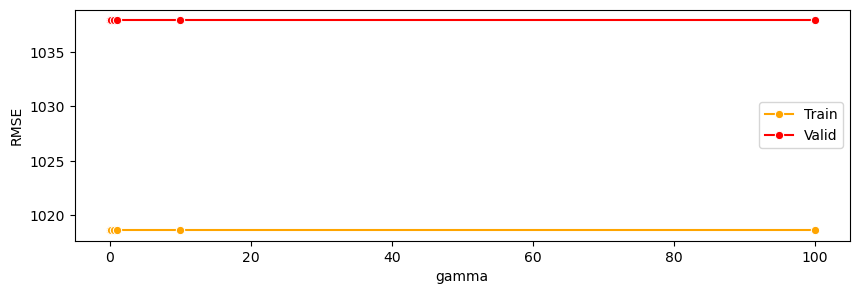

In [26]:
plt.figure(figsize= (10,3), dpi= 100)
sns.lineplot(x= gamma_results['gamma'], y= gamma_results['train'], color = 'orange', marker= 'o', label= 'Train')
sns.lineplot(x= gamma_results['gamma'], y= gamma_results['valid'], color = 'red', marker= 'o', label= 'Valid')
plt.xlabel('gamma')
plt.ylabel('RMSE')
plt.legend()
plt.show()

* The value of gamma is also not making much difference to the model performance.
* We will keep the value of gamma fixed to 0.

### 5. subsample

In [19]:
def ss_score(data):
    
    X = data.drop(columns = 'Item_Outlet_Sales', axis= 1)
    Y = data['Item_Outlet_Sales']
    
    KF = KFold(n_splits= 5, shuffle= True, random_state= 0)
    
    results= []
    
    for ss in tqdm_notebook([ 0.01, 0.05, 0.075, 0.1, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.97, 0.99, 0.999, 1], desc="Processing", leave=True):
        x = {}
        train_score = []
        val_score = []
        
        for i, (train_index, val_index) in enumerate(KF.split(X, Y)):
            xtr, xval = X.iloc[train_index], X.iloc[val_index]
            ytr, yval = Y.iloc[train_index], Y.iloc[val_index]
        
            model = XGBRegressor(n_estimators = 300,
                                 max_depth = 4,
                                    learning_rate = 0.01,
                                 min_child_weight = 10,
                                 gamma = 0,
                                 subsample= ss,
                                    n_jobs = 4,
                                    random_state = 0,
                                    objective = 'reg:squarederror')
            
            model.fit(xtr, ytr)

            train_preds = model.predict(xtr)
            val_preds = model.predict(xval)

            train_rmse = np.sqrt(mse(ytr, train_preds))
            val_rmse = np.sqrt(mse(yval, val_preds))

            train_score.append(train_rmse)
            val_score.append(val_rmse)
            
            
        mean_score_train = np.mean(train_score)
        mean_score_valid = np.mean(val_score)

        print('With subsample:\t' + str(ss) + '\tMean_RMSLE_Train:\t' + str(mean_score_train) + '\tMean_RMSLE_Valid:\t' + str(mean_score_valid))
                 
        x['subsample'] = ss
        x['train'] = mean_score_train
        x['valid'] = mean_score_valid
    
        results.append(x)
        
    return pd.DataFrame(results)

In [20]:
ss_results = ss_score(scaled_df)

Processing:   0%|          | 0/14 [00:00<?, ?it/s]

With subsample:	0.01	Mean_RMSLE_Train:	1124.488967951367	Mean_RMSLE_Valid:	1129.0526689751991
With subsample:	0.05	Mean_RMSLE_Train:	1032.5635415294564	Mean_RMSLE_Valid:	1046.8420712763927
With subsample:	0.075	Mean_RMSLE_Train:	1026.3453002403999	Mean_RMSLE_Valid:	1042.9651117540511
With subsample:	0.1	Mean_RMSLE_Train:	1023.6058819398602	Mean_RMSLE_Valid:	1040.1015043203272
With subsample:	0.4	Mean_RMSLE_Train:	1017.1557041801916	Mean_RMSLE_Valid:	1037.7575441908068
With subsample:	0.6	Mean_RMSLE_Train:	1017.2833883305245	Mean_RMSLE_Valid:	1037.252663183968
With subsample:	0.7	Mean_RMSLE_Train:	1017.4516171536418	Mean_RMSLE_Valid:	1037.6453418398917
With subsample:	0.8	Mean_RMSLE_Train:	1017.7038012772467	Mean_RMSLE_Valid:	1037.6365655650638
With subsample:	0.9	Mean_RMSLE_Train:	1018.3124678284373	Mean_RMSLE_Valid:	1037.5468007791885
With subsample:	0.95	Mean_RMSLE_Train:	1018.3751065278184	Mean_RMSLE_Valid:	1037.5701842283067
With subsample:	0.97	Mean_RMSLE_Train:	1018.5990782699289

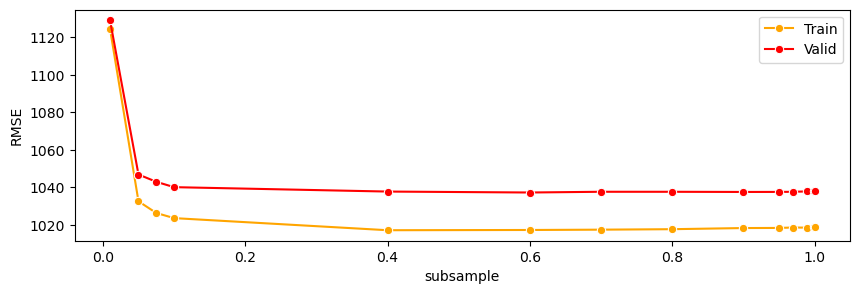

In [24]:
plt.figure(figsize= (10,3), dpi= 100)
sns.lineplot(x= ss_results['subsample'], y= ss_results['train'], color = 'orange', marker= 'o', label= 'Train')
sns.lineplot(x= ss_results['subsample'], y= ss_results['valid'], color = 'red', marker= 'o', label= 'Valid')
plt.xlabel('subsample')
plt.ylabel('RMSE')
plt.legend()
plt.show()

validation **RMSE (1037.25)** is lowest at **subsample = 0.6**

### CONCLUSION:
Best hyperparameters for XGBoostRegresor are:
* n_estimators: 300
* max_depth: 4
* min_child_weight: 10
* gamma: 0
* subsample: 0.6